<a href="https://colab.research.google.com/github/Oriolrt/MVC_M2_PGM/blob/main/Guided_Exercise/3_Guided_Exercise_FourOrder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Guided Exercise

This guided exercise is devoted to learn how to implement a Conditional Random Field (CRF) to solve typical image processing tasks. It is composed of two parts: first, we will see how to model a given problem using CRF. Then, we will apply available inference algorithms on PGM to evaluate their performance

In [ ]:
# @title Install pylibDAI and other dependencies
#!nvidia-smi
# We install required libraries
!apt-get install libboost-dev libboost-graph-dev libboost-program-options-dev libboost-test-dev libgmp-dev cimg-dev
!pip install Pillow networkx
!pip install git+https://github.com/Oriolrt/pylibdai.git

In [ ]:
# @title
!apt update
!apt install imagemagick
!apt install pdf2svg
!apt install texlive texlive-latex-extra
!pip install git+https://github.com/mkrphys/ipython-tikzmagic.git
%load_ext tikzmagic



In [1]:
# @title
# We import libraries
from dai import dai
import numpy as np
import sklearn
from IPython.display import Image
from time import time

import pickle
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
def energy(x, y, pairwise):
    # x is unaries
    # y is a labeling
    n_states = pairwise.shape[0]
    ## unary features:
    gx, gy = np.ogrid[:x.shape[0], :x.shape[1]]
    selected_unaries = x[gx, gy, y.astype(int)]
    unaries_acc = np.sum(x[gx, gy, y.astype(int)])
    unaries_acc = np.bincount(y.astype(int).ravel(), selected_unaries.ravel(),
                              minlength=n_states)

    ##accumulated pairwise
    #make one hot encoding
    labels = np.zeros((y.shape[0], y.shape[1], n_states),
                      dtype=np.int32)
    gx, gy = np.ogrid[:y.shape[0], :y.shape[1]]
    labels[gx, gy, y.astype(int)] = 1
    # vertical edges
    vert = np.dot(labels[1:, :, :].reshape(-1, n_states).T,
                  labels[:-1, :, :].reshape(-1, n_states))
    # horizontal edges
    horz = np.dot(labels[:, 1:, :].reshape(-1, n_states).T,
                  labels[:, :-1, :].reshape(-1, n_states))
    pw = vert + horz
    pw = pw + pw.T - np.diag(np.diag(pw))
    energy = np.dot(np.tril(pw).ravel(), pairwise.ravel()) + unaries_acc.sum()
    return energy


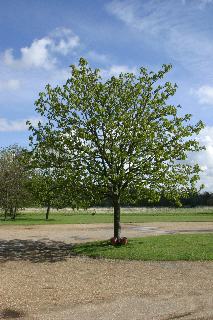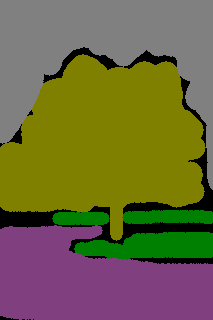
## Show image


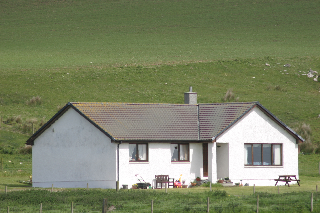

In [2]:
from PIL import Image
from typing import ValuesView
image = Image.open('3_12_s.bmp')
# show the image
image


We will cluster image pixels according their colors using Gaussian Mixture Models

In [3]:
# Gaussian Mixture Model libraries
from sklearn import mixture
from numpy import asarray

# TODO: play with the values of k and smooth_term
k=6
smooth_term = [0.0, 0.2]


potential=asarray(image)
midaOriginal = potential.shape
newShape=(*midaOriginal[:2],k)
print(f"Size of the original image: {potential.shape}")
potential=potential.reshape( (midaOriginal[0]*midaOriginal[1], midaOriginal[2]))
print(f"Size of the Unary potentials: {potential.shape}")

gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(potential)

mean_color = gmm.means_.astype(int)

y = gmm.predict(potential)
segmented_image = mean_color[y]
segmented_image = segmented_image.reshape(midaOriginal)

# Get the probabilities (responsibilities) for each component
probs = gmm.predict_proba(potential)

unary_term = -np.log(probs + 1e-10)

Size of the original image: (213, 320, 3)
Size of the Unary potentials: (68160, 3)


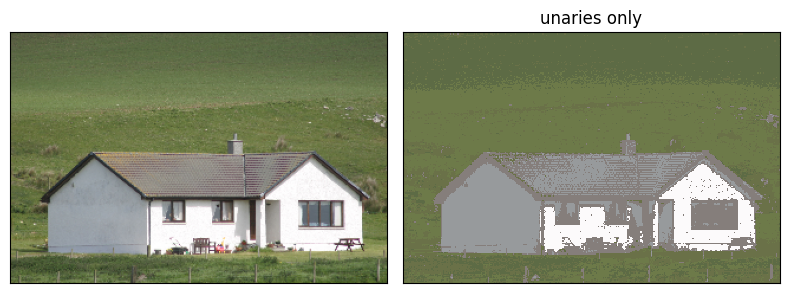

In [4]:
fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("unaries only")
axes[1].matshow(segmented_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()

## Building the Model

A key step is the construction of the factor graph representation that will represent the dependencies between random variables (represented as nodes in the graph).

As we want represent each pixel as a random variable which is 4-connected to adjacent pixels (a regular grid), we must define a graph that takes into account this topology. A candidate model is the factor graph shown below. The blue nodes, $x$, represent the observations (image) and white nodes, $y$, represent the latent (or hidden) variables.



In [5]:
# @title
%%tikz -l arrows,shapes,fit,positioning,calc,shadows,matrix  --scale 2 --size 300,300 -f svg
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 30 pt, drop shadow, fill=white!20] (yi) {$y_{i}$};
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 30 pt, drop shadow, fill=white!20,right=of yi] (yiN) {$y_{i+N}$};
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 30 pt, drop shadow, fill=white!20,below=of yi] (yii) {$y_{i+1}$} ;
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 30 pt, drop shadow, fill=white!20,below=of yiN] (yiiN) {$y_{q}$};
\node[draw, fill           = black,   text           = red,  drop shadow,label=left:$f_c$] at ($0.25*(yi) + 0.25*(yiN) + 0.25*(yii) + 0.25*(yiiN)$) {} edge (yii) edge (yi) edge (yiN) edge (yiiN);


SyntaxError: unexpected character after line continuation character (3007360532.py, line 3)

We will first define the function __BuildFourORderFactorGraph__ that given an image will return  a list of __factors__. Each factor is define by a tuple of the form:  *( m , f )* , where *m* is a list of variable indices and *f* corresponds to a n-dimensional array  with the factor values.

This function also returns, as second element, the energy of the factor graph.

In [10]:
def BuildFourOrderFactorGraph(image: Image, num_states: int = 1, theta: list = [0.0, 2.0], obs_probs: np.array = None):
    potential = asarray(image)
    midaOriginal = potential.shape
    nFils = midaOriginal[0]
    nCols = midaOriginal[1]
    nNodes = nFils * nCols

    inds = np.arange(nNodes).reshape(midaOriginal[:2]).astype(np.int64)

    # Unary factors
    if obs_probs is not None:
        unary_factors = [([m], p) for m, p in zip(inds.reshape(-1), obs_probs)]
    else:
        unary_factors = []

    # Create pairwise-compatible energy matrix
    energy = theta[0]*np.eye(num_states) + theta[1]*(np.ones(num_states)-np.eye(num_states))
    pairwise_exp = np.exp(-energy)

    # Create four-order connections that decompose to pairwise
    down_edges = [(i,i+1) for i in range(nNodes) if (i+1) % nFils != 0]
    right_edges = [(i,i+nFils) for i in range(nNodes-nFils)]
    diagonal_edges = [(i,i+nFils+1) for i in range(nNodes-nFils) if (i+1) % nFils != 0]
    cross_edges = [(i+1,i+nFils) for i in range(nNodes-nFils) if (i+1) % nFils != 0]

    # Combine all edges
    all_edges = down_edges + right_edges + diagonal_edges + cross_edges
    
    # Create factors
    pairwise_factors = [(edge, pairwise_exp) for edge in all_edges]

    return unary_factors + pairwise_factors, -energy

In [16]:
factor_list, pairwise = BuildFourOrderFactorGraph( image, num_states=k , obs_probs=probs,theta=smooth_term )

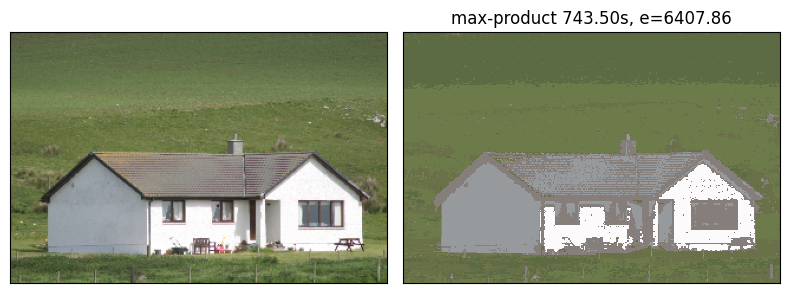

In [12]:
props = {'inference': 'MAXPROD', 'updates': 'SEQRND', 'tol': '1e-6', 'maxiter': '10', 'logdomain': '0','damping':0.1}
start = time()
qv, qf,  max_product = dai(factor_list, method= 'BP', props=props,with_beliefs=True)
time_maxprod = time() - start
max_product_image = mean_color[max_product.astype(int)]
max_product_image = max_product_image.reshape(midaOriginal)
energy_max_prod = energy(unary_term.reshape(newShape) , max_product.reshape(midaOriginal[:2]), pairwise)

fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("max-product %.2fs, e=%.2f"% (time_maxprod, energy_max_prod))
axes[1].matshow(max_product_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()

Starting BP[tol=1e-06,maxiter=10,maxtime=inf,verbose=1,logdomain=0,updates=SEQRND,damping=0.1,inference=SUMPROD]...
BP::run:  WARNING: not converged after 10 passes (17.1895 seconds)...final maxdiff:9.61426e-05


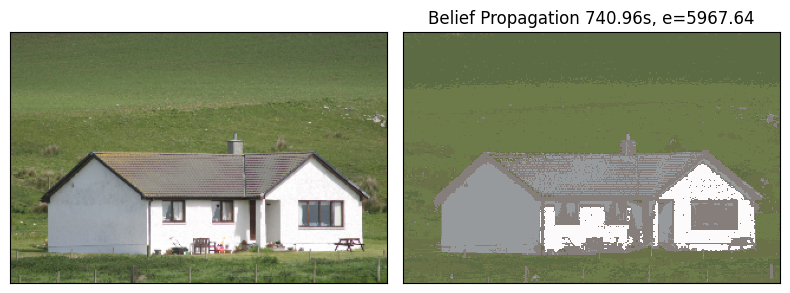

In [15]:
props = {'inference': 'SUMPROD', 'updates': 'SEQRND', 'tol': '1e-6', 'maxiter': '10', 'logdomain': '0','damping':0.1,'verbose':1}
start = time()
qv, qf, bp = dai(factor_list, method='BP', props=props,with_beliefs=True)
time_bp = time() - start
bp_image = mean_color[bp.astype(int)]
bp_image = bp_image.reshape(midaOriginal)
energy_bp = energy(unary_term.reshape(newShape), bp.reshape(midaOriginal[:2]), pairwise)

fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("Belief Propagation %.2fs, e=%.2f"% (time_bp, energy_bp))
axes[1].matshow(bp_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()

Starting GIBBS[maxiter=100,maxtime=inf,restart=100,burnin=0,verbose=1]...

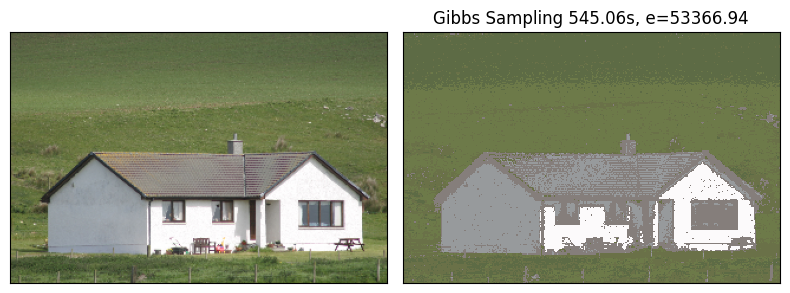

In [17]:
props = {'inference': 'SUMPROD', 'updates': 'SEQRND', 'tol': '1e-2', 'maxiter': '100', 'logdomain': '0','burnin':0,'verbose':1 }
start = time()
qv, qf, gibbs = dai(factor_list, method='GIBBS', props=props,with_beliefs=True)
time_gibbs = time() - start
gibbs_image = mean_color[gibbs.astype(int)]
gibbs_image = gibbs_image.reshape(midaOriginal)
energy_gibbs =   energy(np.array([ x.tolist() for (m,x) in qv]).reshape(newShape) , gibbs.reshape(midaOriginal[:2]), pairwise)

fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("Gibbs Sampling %.2fs, e=%.2f"% (time_gibbs, energy_gibbs))
axes[1].matshow(gibbs_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()
